In [50]:
import numpy as np
import pathlib
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))


In [51]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

#Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

# Define training and test directory paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"


# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator training instance with data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2, # rotate the image slightly
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis
test_datagen = ImageDataGenerator(rescale=1/255.)

# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32,
                                               shuffle=True)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)


--2021-07-13 15:32:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109579078 (105M) [application/zip]
Saving to: ‘pizza_steak.zip.11’

pizza_steak.zip.11  100%[===================>] 104.50M   134MB/s    in 0.8s    

2021-07-13 15:32:02 (134 MB/s) - ‘pizza_steak.zip.11’ saved [109579078/109579078]

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [52]:
# import libs
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [53]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])


In [54]:
# Compile
model_4.compile(loss='binary_crossentropy',
                optimizer = Adam(),
                metrics=['accuracy'])

In [55]:
# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        verbose=0)


You'll notice two new parameters here:

steps_per_epoch - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of train_data (1500 images in batches of 32 = 1500/32 = ~47 steps)
validation_steps - same as above, except for the validation_data parameter (500 test images in batches of 32 = 500/32 = ~16 steps)


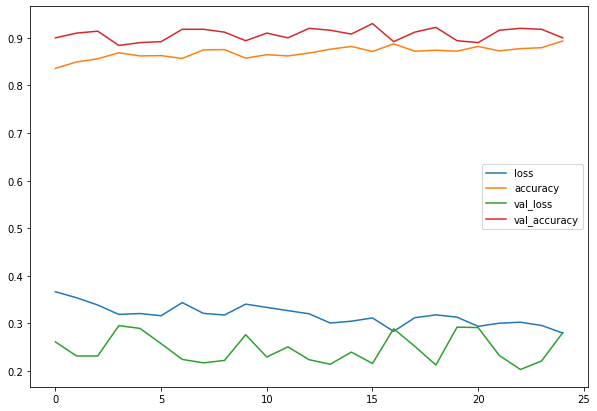

In [56]:


# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));


In [57]:
# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


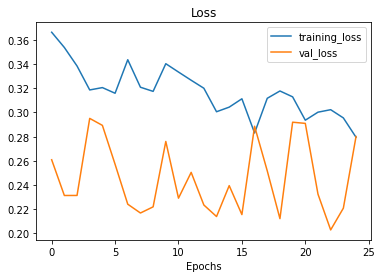

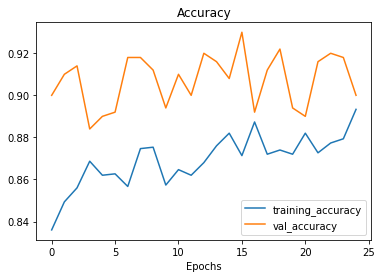

In [58]:
# Check out the loss curves of model_4
plot_loss_curves(history_4)


In [59]:
# Check out our model's architecture
model_4.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6760)              0

In [60]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img


In [61]:
import tensorflow as tf
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
# Load in and preprocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
# Add an extra axis
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak

--2021-07-13 15:40:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg.2’

03-steak.jpeg.2     100%[===================>]   1.89M  --.-KB/s    in 0.07s   

2021-07-13 15:40:48 (28.7 MB/s) - ‘03-steak.jpeg.2’ saved [1978213/1978213]

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],

        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],

        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],

        ...,

        [[0.49313724, 0.42745098, 

In [62]:
pred = model_8.predict(steak)
pred

array([[0.57931143]], dtype=float32)

In [63]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);


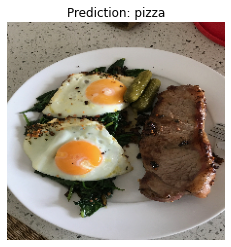

In [64]:
# Test our model on a custom image
pred_and_plot(model_8, "03-steak.jpeg", class_names)


--2021-07-13 15:40:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg.1’

03-pizza-dad.jpeg.1 100%[===================>]   2.74M  --.-KB/s    in 0.1s    

2021-07-13 15:40:49 (27.0 MB/s) - ‘03-pizza-dad.jpeg.1’ saved [2874848/2874848]



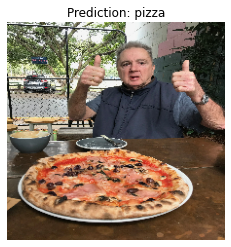

In [65]:
# Download another test image and make a prediction on it
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg 
pred_and_plot(model_8, "03-pizza-dad.jpeg", class_names)


In [66]:
class_names

array(['.DS_Store', 'pizza', 'steak'], dtype='<U9')